In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"surajkumaryadav01","key":"4c68a36d197908340900ff1cd4c9b936"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

 97% 115M/119M [00:01<00:00, 133MB/s] 
100% 119M/119M [00:01<00:00, 107MB/s]


In [ ]:
!unzip chest-ctscan-images.zip

Archive:  chest-ctscan-images.zip
  inflating: Data/test/adenocarcinoma/000108 (3).png  
  inflating: Data/test/adenocarcinoma/000109 (2).png  
  inflating: Data/test/adenocarcinoma/000109 (4).png  
  inflating: Data/test/adenocarcinoma/000109 (5).png  
  inflating: Data/test/adenocarcinoma/000112 (2).png  
  inflating: Data/test/adenocarcinoma/000113 (7).png  
  inflating: Data/test/adenocarcinoma/000114 (5).png  
  inflating: Data/test/adenocarcinoma/000114.png  
  inflating: Data/test/adenocarcinoma/000115 (4).png  
  inflating: Data/test/adenocarcinoma/000115 (8).png  
  inflating: Data/test/adenocarcinoma/000115.png  
  inflating: Data/test/adenocarcinoma/000116 (5).png  
  inflating: Data/test/adenocarcinoma/000116 (7).png  
  inflating: Data/test/adenocarcinoma/000116 (9).png  
  inflating: Data/test/adenocarcinoma/000117 (4).png  
  inflating: Data/test/adenocarcinoma/000117 (8).png  
  inflating: Data/test/adenocarcinoma/000117.png  
  inflating: Data/test/adenocarcinoma/00011

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input


import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_path = "Data/train"
val_path = "Data/valid"
test_path = "Data/test"

In [ ]:
train_path

'Data/train'

In [ ]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;

train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)
print(train_set,"\n\n",val_set,"\n\n",test_set)

{'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 115, 'normal': 148, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 155, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 195} 

 {'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 21, 'normal': 13, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 15, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 23} 

 {'large.cell.carcinoma': 51, 'squamous.cell.carcinoma': 90, 'normal': 54, 'adenocarcinoma': 120}


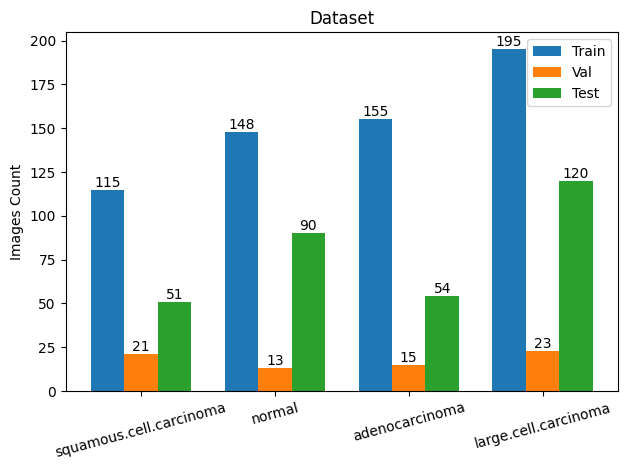

In [ ]:
labels = ['squamous.cell.carcinoma', 'normal', 'adenocarcinoma', 'large.cell.carcinoma']

train_list = list(train_set.values())
val_list = list(val_set.values())
test_list = list(test_set.values())

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_list, width, label='Train')
rects2 = ax.bar(x, val_list, width, label='Val')
rects3 = ax.bar(x + width, test_list, width, label='Test')

ax.set_ylabel('Images Count')
ax.set_title('Dataset')
ax.set_xticks(x, labels)
plt.xticks(rotation=15)
ax.legend()
ax.bar_label(rects1)
ax.bar_label(rects2)
ax.bar_label(rects3)

fig.tight_layout()
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest',
                                  zoom_range=0.2,
                                  shear_range = 0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=0.4)

train_data = train_datagen.flow_from_directory(train_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

train_data.class_indices

Found 613 images belonging to 4 classes.


{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [ ]:
val_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_data = val_datagen.flow_from_directory(val_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')
val_data.class_indices

Found 72 images belonging to 4 classes.


{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_data = test_datagen.flow_from_directory(test_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')
test_data.class_indices

Found 315 images belonging to 4 classes.


{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

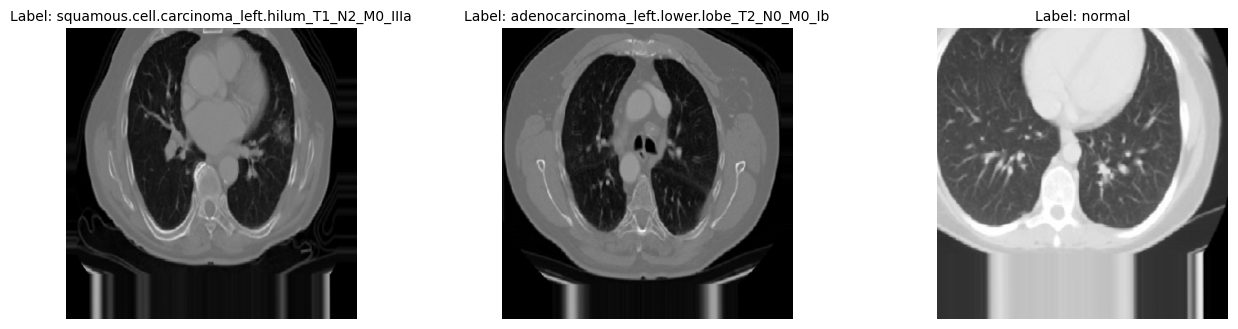

In [ ]:

def plot_sample_images(images, labels, class_indices):
    class_labels = list(class_indices.keys())
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    fig.subplots_adjust(wspace=0.5)

    for i in range(len(images)):
        axs[i].imshow(images[i])
        axs[i].set_title("Label: {}".format(class_labels[np.argmax(labels[i])]), fontsize=10)  # Adjust fontsize as needed
        axs[i].axis('off')

    plt.show()

sample_images, sample_labels = next(train_data)
plot_sample_images(sample_images[:3], sample_labels[:3], train_data.class_indices)

In [ ]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(350,350,3)
)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
NUM_CLASSES = 4

vgg_model = Sequential()

vgg_model.add(base_model)

vgg_model.add(layers.Flatten())

vgg_model.add(layers.Dropout(0.25))

vgg_model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

vgg_model.layers[0].trainable = False

vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
mc = ModelCheckpoint(
    filepath="./ct_vgg_best_model.hdf5",
    monitor= 'val_accuracy',
    verbose= 1,
    save_best_only= True,
    mode = 'auto'
    );

call_back = [ mc];

In [ ]:
vgg = vgg_model.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size,
    epochs = 32,
    validation_data = val_data,
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back
    )

Epoch 1/32
122/122 [==============================] - ETA: 0s - loss: 2.5148 - accuracy: 0.4227
Epoch 1: val_accuracy improved from -inf to 0.57143, saving model to ./ct_vgg_best_model.hdf5
122/122 [==============================] - 31s 196ms/step - loss: 2.5148 - accuracy: 0.4227 - val_loss: 1.0412 - val_accuracy: 0.5714
Epoch 2/32
122/122 [==============================] - ETA: 0s - loss: 1.6278 - accuracy: 0.5905
Epoch 2: val_accuracy did not improve from 0.57143
122/122 [==============================] - 23s 184ms/step - loss: 1.6278 - accuracy: 0.5905 - val_loss: 1.5482 - val_accuracy: 0.5286
Epoch 3/32
122/122 [==============================] - ETA: 0s - loss: 1.7424 - accuracy: 0.6020
Epoch 3: val_accuracy did not improve from 0.57143
122/122 [==============================] - 23s 189ms/step - loss: 1.7424 - accuracy: 0.6020 - val_loss: 2.3506 - val_accuracy: 0.4714
Epoch 4/32
122/122 [==============================] - ETA: 0s - loss: 1.2661 - accuracy: 0.6924
Epoch 4: val_accur

In [ ]:
model = load_model("ct_vgg_best_model.hdf5")

accuracy_vgg = model.evaluate_generator(generator= test_data)[1]
print(f"The accuracy of the model is = {accuracy_vgg*100} %")
loss_vgg = model.evaluate_generator(generator= test_data)[0]
print(f"The loss of the model is = {loss_vgg}")

The accuracy of the model is = 76.82539820671082 %
The loss of the model is = 0.9585340619087219


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(350, 350))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

def predict_image(model, image_path):
    img_array = preprocess_image(image_path)
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    class_mapping = {
        0: 'adenocarcinoma',
        1: 'large.cell.carcinoma',
        2: 'normal',
        3: 'squamous.cell.carcinoma'
    }
    predicted_class = class_mapping[predicted_class_index]
    predicted_probability = prediction[0][predicted_class_index]
    return predicted_class, predicted_probability

input_image_path = "img1.png"

predicted_class, predicted_probability = predict_image(model, input_image_path)

print("Predicted Class:", predicted_class)
print("Probability:", predicted_probability)

1/1 [==============================] - 2s 2s/step
Predicted Class: squamous.cell.carcinoma
Probability: 0.55808216


In [ ]:
input_image_path = "img2.png"

predicted_class, predicted_probability = predict_image(model, input_image_path)

print("Predicted Class:", predicted_class)
print("Probability:", predicted_probability)


1/1 [==============================] - 0s 30ms/step
Predicted Class: large.cell.carcinoma
Probability: 0.9272327


In [ ]:
input_image_path = "img3.png"

predicted_class, predicted_probability = predict_image(model, input_image_path)

print("Predicted Class:", predicted_class)
print("Probability:", predicted_probability)


1/1 [==============================] - 0s 29ms/step
Predicted Class: squamous.cell.carcinoma
Probability: 0.5443354


In [ ]:
input_image_path = "img4.png"

predicted_class, predicted_probability = predict_image(model, input_image_path)

print("Predicted Class:", predicted_class)
print("Probability:", predicted_probability)


1/1 [==============================] - 0s 35ms/step
Predicted Class: normal
Probability: 0.9992625
